# Daily Motivation Quotes


## Business Understanding

In a world filled with daily challenges and responsibilities, staying motivated is essential for personal growth and well-being. This data science project is dedicated to curating and delivering a diverse collection of carefully selected quotes. These inspirational snippets, sourced from various outlets including historical figures, popular literature, and notable personalities, aim to provide a source of encouragement, reflection, and empowerment for individuals facing the hustle of everyday life.

#### Objectives:

The primary objectives of this project are as follows:
1.	Curate Inspirational Quotes:
Gather a diverse collection of quotes from the Good Reads website, which boasts an extensive compilation of quotes spanning various genres and themes.
2.	Daily Motivational Updates: Develop a system to provide users with daily updates featuring a thoughtfully chosen quote. These updates will cater to different areas of life, ensuring a comprehensive and relatable experience.
3.	Tag-based Grouping: Implement a categorization mechanism that tags each quote based on its thematic content. This grouping will enable users to easily identify quotes that resonate with their specific preferences or current situations.


## Data Understanding

•	Source quotes from the Good Reads website, exploring the wide array of authors and themes available.

•	Analyze the structure of the collected data, including metadata such as author names, publication dates, and associated tags.


In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import scrapy 
import zipfile
#from pathlib import path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist
import plotly.express as px

from langdetect import detect
from googletrans import Translator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob



from my_functions import translate_to_english, preprocess_text, preprocesss_text, compress_tags, clean_text

### 3.	Data Preparation
After obtaining the data we intend to use, we wil now open it here and begin the data cleaning process before proceeding to analysis.

In [46]:
# Reading the data
quotes = pd.read_csv(r'data/Quotes.csv', index_col=0)

# Read new dataset. 
"""We will reaad it directly from the Zipfile"""
with zipfile.ZipFile('data/tweets data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    
#Read the data into a data frame
tweets = pd.read_csv(r'data/Tweets.csv')


In [47]:
quotes

,Author Name,Quote,Tags
0,Oscar Wilde,“Be yourself; everyone else is already taken.”...,"['attributed-no-source', 'be-yourself', 'gilbe..."
1,Marilyn Monroe,"“I'm selfish, impatient and a little insecure....","['attributed-no-source', 'best', 'life', 'love..."
2,Albert Einstein,“Two things are infinite: the universe and hum...,"['attributed-no-source', 'human-nature', 'humo..."
3,Frank Zappa,"“So many books, so little time.” ― F...","['books', 'humor']"
4,Marcus Tullius Cicero,“A room without books is like a body without a...,"['attributed-no-source', 'books', 'simile', 's..."
...,...,...,...
2995,"A.A. Milne,",“I'm not lost for I know where I am. But howev...,NaN
2996,Henry David Thoreau,“Dreams are the touchstones of our characters....,NaN
2997,"Cassandra Clare,",“Black hair and blue eyes are my favorite comb...,NaN
2998,"Nicholas Sparks,",“In times of grief and sorrow I will hold you ...,NaN


We observe that the tags column did not get all the tags for the quotes and we will need to fill them up or remove them if that will not be possible. 
Although removing them will really affect the number of quotes availabe for us to use, therefore removing them will be a last resort. 
We will attempt to fill them based on the author. 

In [48]:
# Checking actual number of missing values. 
quotes.isna().sum()

Author Name      0
Quote            0
Tags           502
dtype: int64

In [49]:
# checking contents of the quote column. 
quotes['Quote'][3]

'“So many books, so little time.”      ―      Frank Zappa'

It appears the quote column still kept the name of the author. We can redo the split again below. We also observe that the quotes have extra quotes that will remain after separating the name from the quote, that will need to be removed as well to only leave a single double quotation mark. 

In [50]:
#  Split the content after the hyphen (―) into 'quote' and 'author' columns
quotes[['quote', 'author']] = quotes['Quote'].str.split('―',  expand=True)

# Strip leading and trailing whitespaces from 'quote' and 'author' columns
quotes['quote'] = quotes['quote'].str.strip()
quotes['author'] = quotes['author'].str.strip()

# Drop the original 'Quote' column since we have extracted its contents
quotes.drop('Quote', axis=1, inplace=True)

In [51]:
nan = quotes[quotes['Tags'].isna()]

In [52]:
nan

,Author Name,Tags,quote,author
2498,"John Green,",NaN,“And then something invisible snapped insider ...,"John Green, Looking for Alaska"
2499,Aristotle,NaN,“Hope is a waking dream.”,Aristotle
2500,Annie Proulx,NaN,“You should write because you love the shape o...,Annie Proulx
2501,Bill Watterson,NaN,“I'm killing time while I wait for life to sho...,Bill Watterson
2502,Alex Haley,NaN,"“Either you deal with what is the reality, or ...",Alex Haley
...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook"


In [53]:
# preview the changes
quotes['quote'][53]

"“If you don't stand for something you will fall for anything.”"

In [54]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


Checking the distribution of the authors and their quotes, we realize that some of them are not actually in english and this would affect the outcome of our code when filling the nan tags. we therefore need to translate them to English before preprocessing them for the fill. 
we can do that using the langdetect package available  in python together with googletrans package. 
we will install them using Pip then restart kernel and import them with the other packages.

Next, we will write a function that will do the translation for us called translate to english that is available in out my functions file. 

In [55]:
# Apply the translation function from my function file to the quote column
#quotes['quote_2'] = quotes['quote'].apply(translate_to_english)


Below we will also apply the translate to english function on the author column to have the names in English. the following codes really took a long time running on my local machine, therefore, I opted to run them using cloud services, i.e. google colab then saved the new dataframe to a new file that we will read below. 

In [56]:
# Apply the translation function from my function file to the author column
# quotes['author_2'] = quotes['Author Name'].apply(translate_to_english)


In [57]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


In [58]:
# Reading the new file 
quotes_2 = pd.read_csv(r'data\quotes_2.csv', index_col=0)
quotes_2

,Author Name,Tags,quote,author,quote_2,author_2
0,Oscar Wilde,"['attributed-no-source', 'be-yourself', 'gilbe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde
1,Marilyn Monroe,"['attributed-no-source', 'best', 'life', 'love...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe
2,Albert Einstein,"['attributed-no-source', 'human-nature', 'humo...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein
3,Frank Zappa,"['books', 'humor']","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa
4,Marcus Tullius Cicero,"['attributed-no-source', 'books', 'simile', 's...",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero
...,...,...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh",“I'm not lost for I know where I am. But howev...,"A.A.Milne,"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel",“Black hair and blue eyes are my favorite comb...,"Cassandra Clare,"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook",“In times of grief and sorrow I will hold you ...,"Nicholas Sparks,"


Below we will perfomt some Data wrangling techniques to ensure we have comprehensive data to work with. 

In [59]:
# Drop duplicate rows across all columns
quotes_2 = quotes_2.drop_duplicates()

In [60]:
# Replace missing values with the most common value of each column in: 'Tags'
quotes_2 = quotes_2.fillna({'Tags': quotes_2['Tags'].mode()[0]})

In [61]:
quotes_2.groupby('Author Name').sum()

,Tags,quote,author,quote_2,author_2
Author Name,,,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh",“It is more fun to talk with someone who doesn...,"A. A. Milne,"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...,"“Weeds are flowers, too, once you get to know ...",A.A.MilneA.A.MilneA.A.MilneA.A.MilneA.A.MilneA...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln...","“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A.Milne,A.A.Milne,A.A.Milne,A.A.Milne,A.A.Mi..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin,"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren,“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...,...,...
جلال الدين الرومي,['love'],“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي,"""Do not be alarmed by your wound, otherwise, h...",Jalal al -Din al -Roumi
عباس محمود العقاد,['love'],“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد,“There is no book I read and do not benefit fr...,Abbas Mahmoud Al -Akkad
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني,“You have something in this world .. So”,Ghassan kanfani


#### Visualizations

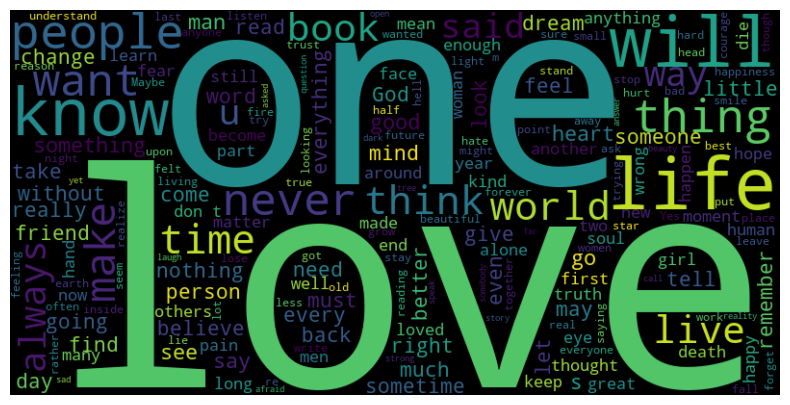

In [62]:
# Word Cloud for the words that appear most in quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['quote_2']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

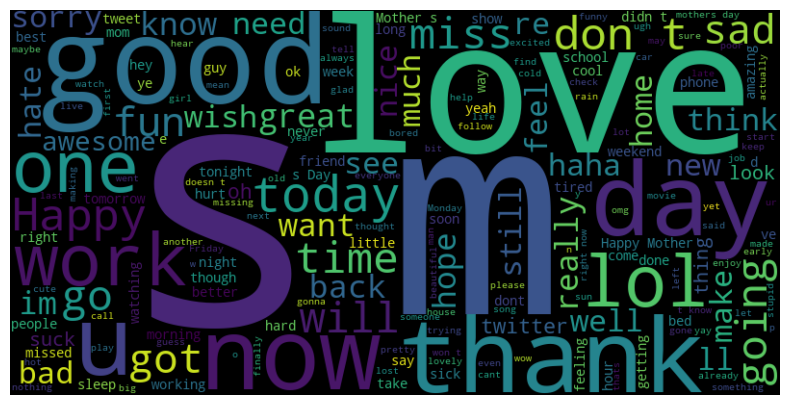

In [63]:
# Word Cloud for the words that appear most in tweets
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(tweets['selected_text'].astype(str)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


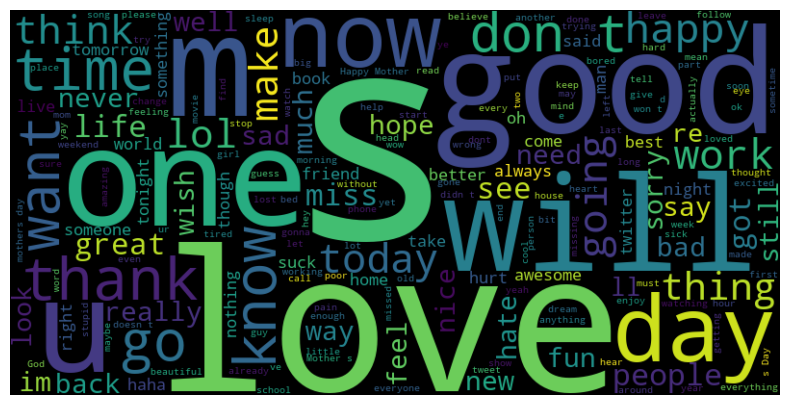

In [64]:
# Combine text from 'selected_text' and 'quote_2'
combined_text = ' '.join(tweets['selected_text'].astype(str)) + ' ' + ' '.join(quotes_2['quote_2'])

# Word Cloud for the words that appear most in both tweets and quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


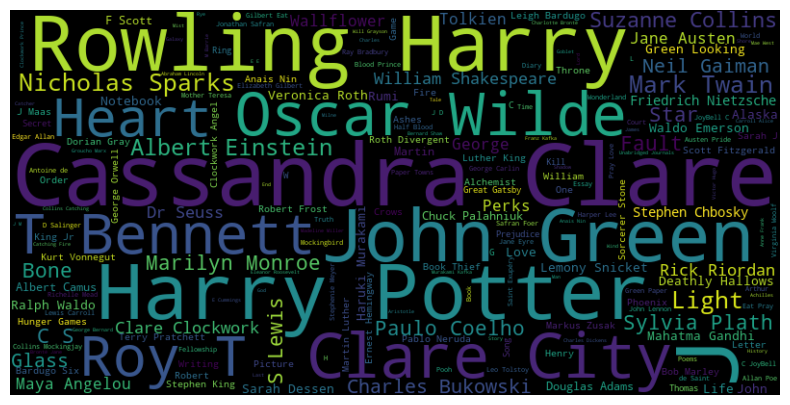

In [65]:
# Word Cloud for the author names that appear the most
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['author']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

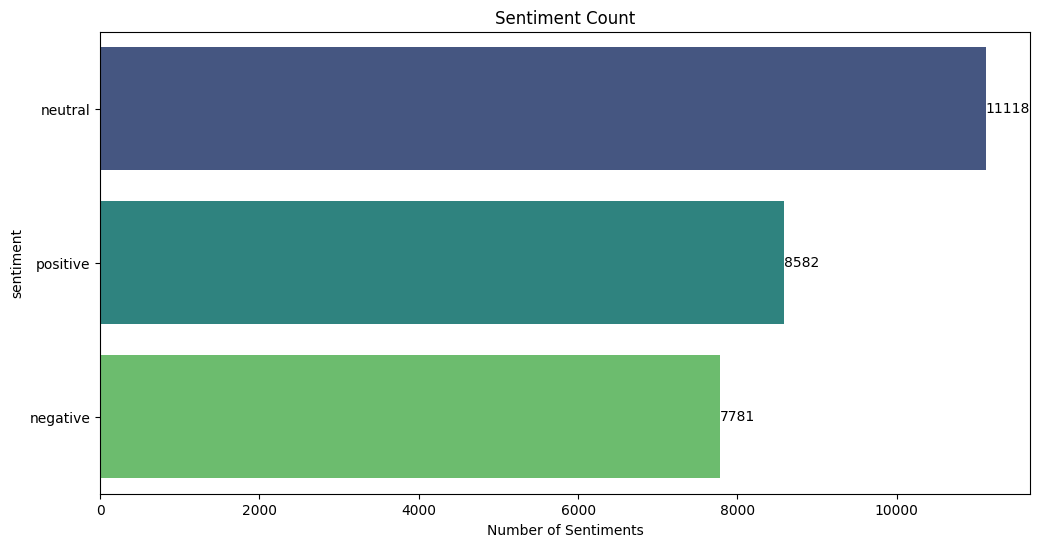

In [66]:
# Sentiment Count Bar Plot
sentiment_count = tweets['sentiment'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_count.values, y=sentiment_count.index, hue=sentiment_count.index, palette='viridis', dodge=False, legend=False)
plt.title('Sentiment Count')
plt.xlabel('Number of Sentiments')

# Adding count labels for each bar
for index, value in enumerate(sentiment_count.values):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.show()


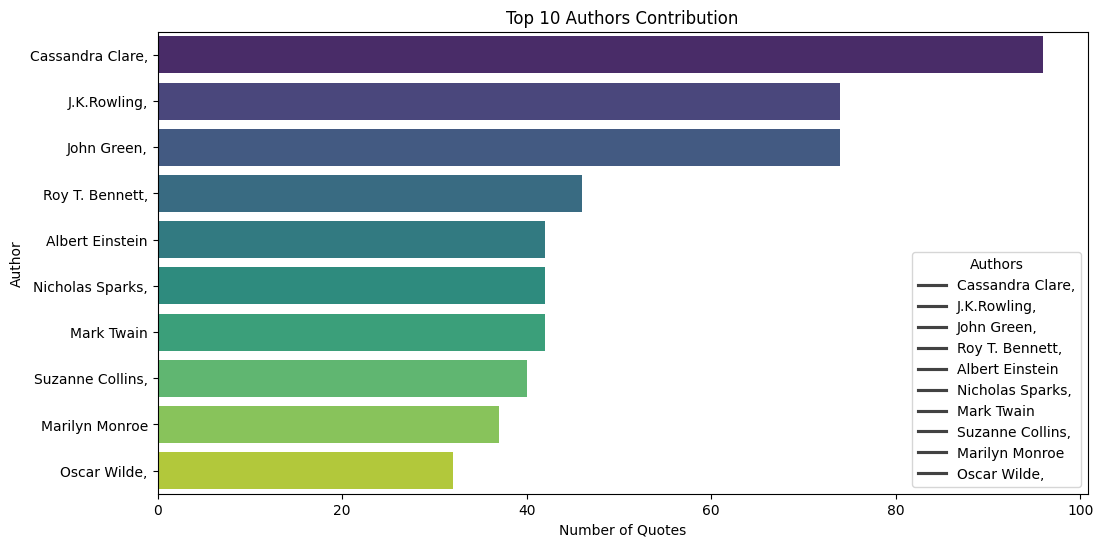

In [67]:
# Author Contribution Bar Chart
author_counts = quotes_2['author_2'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=author_counts.values, y=author_counts.index, hue=author_counts.index, palette='viridis', dodge=False)
plt.title('Top 10 Authors Contribution')
plt.xlabel('Number of Quotes')
plt.ylabel('Author')
plt.legend(title='Authors', loc='lower right', labels=author_counts.index)
plt.show()


In [68]:
# def preprocess_tags(tags_list):
#     # Convert tags to lowercase and remove leading/trailing whitespaces
#     return [tag.lower().strip() for tag in tags_list]

# def compress_tags(tags_list):
#     return list(set(tags_list))[:5]

# quotes_2['Processed_Tags'] = quotes_2['Tags'].apply(preprocess_tags)
# quotes_2['Compressed_Tags'] = quotes_2['Processed_Tags'].apply(compress_tags)

# # Display the resulting DataFrame
# print(quotes_2[['Tags', 'Compressed_Tags']])

In [69]:


# Assuming quotes_2 is your DataFrame and 'Tags' is the column containing lists of tags as strings
quotes_2['Tags'] = quotes_2['Tags'].apply(eval)  # Convert string representation to actual list

# def preprocess_tags(tags_list):
#     # Convert tags to lowercase and remove leading/trailing whitespaces
#     return [tag.lower().strip() for tag in tags_list]



quotes_2['Compressed_Tags'] = quotes_2['Tags'].apply(compress_tags)

# Display the resulting DataFrame
print(quotes_2[['Tags', 'Compressed_Tags']])


                                                   Tags  \
0     [attributed-no-source, be-yourself, gilbert-pe...   
1     [attributed-no-source, best, life, love, misat...   
2     [attributed-no-source, human-nature, humor, in...   
3                                        [books, humor]   
4           [attributed-no-source, books, simile, soul]   
...                                                 ...   
2995                                             [love]   
2996                                             [love]   
2997                                             [love]   
2998                                             [love]   
2999                                             [love]   

                                        Compressed_Tags  
0     [gilbert-perreira, honesty, quote-investigator...  
1        [out-of-control, life, truth, worst, mistakes]  
2     [humor, infinity, science, human-nature, unive...  
3                                        [books, humor]  
4

In [70]:
# Assuming 'Compressed_Tags' is the column containing lists of tags

quotes_2['Tags_'] = quotes_2['Compressed_Tags'].apply(tuple)  # Convert lists to tuples


# Tag Distribution Pie Chart
tag_counts = quotes_2.groupby(by='Tags_').size().nlargest(10).reset_index(name='Count')
fig = px.pie(tag_counts, names='Tags_', values='Count', title='Tags Distribution', 
             custom_data=['Tags_'])  # Add 'Tags_' to custom_data

# Update layout to display custom data on hover
fig.update_traces(hovertemplate='Tag: %{customdata[0]}<br>Count: %{value}')

fig.show()


We observe that the love tag has the highest number of quotes, but upon further investigation of the data, i fund out that the fill we used for the nan present in the column mostly filled them with Love some of which were wrongly filles since the quote was not  about love.<br>
We will continue with the visualizations now to further investigate the Tags column to see if there are any other anomalies present. 

In [71]:
tag_counts = quotes_2.groupby(by='Tags_').sum().tail(20)

fig = px.pie(tag_counts, names=tag_counts.index, title='Tag Distribution')

fig.update_traces(textfont_size=12, textinfo='percent + label') # increase the text size

fig.update_traces(marker=dict(colors=[ 'magenta' , 'yellow' , 'grey' , 'green' , 'purple' , 'slategrey' , 'blue' , 'black' ])) # update the pie chart colors

fig.show()

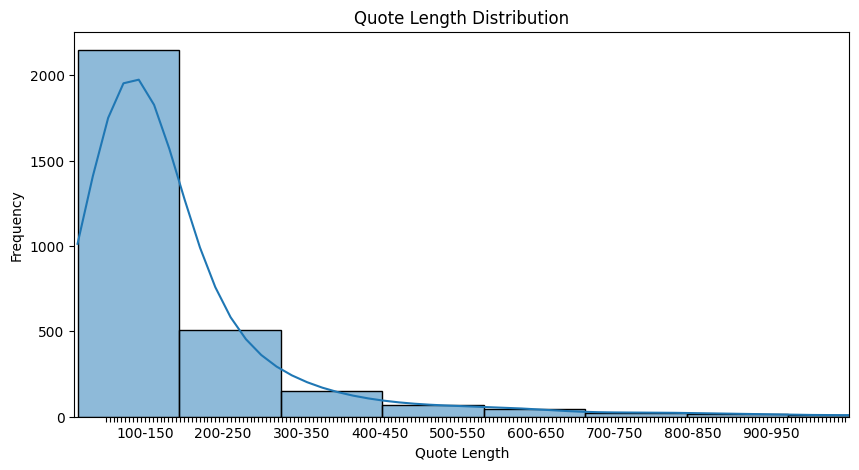

In [72]:
# Quote Length Distribution
quote_lengths = quotes_2['quote'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(quote_lengths, bins=30, kde=True)
plt.title('Quote Length Distribution')
plt.xlabel('Quote Length')
plt.ylabel('Frequency')
plt.xlim([10, 1000])
xticks = np.arange(50, 1000, 5)

# Create custom labels based on your requirements
custom_labels = [f'{i}-{i + 50}' if i % 100 == 0 else '' for i in xticks]

plt.xticks(xticks, labels=custom_labels)


plt.show()

### EDA

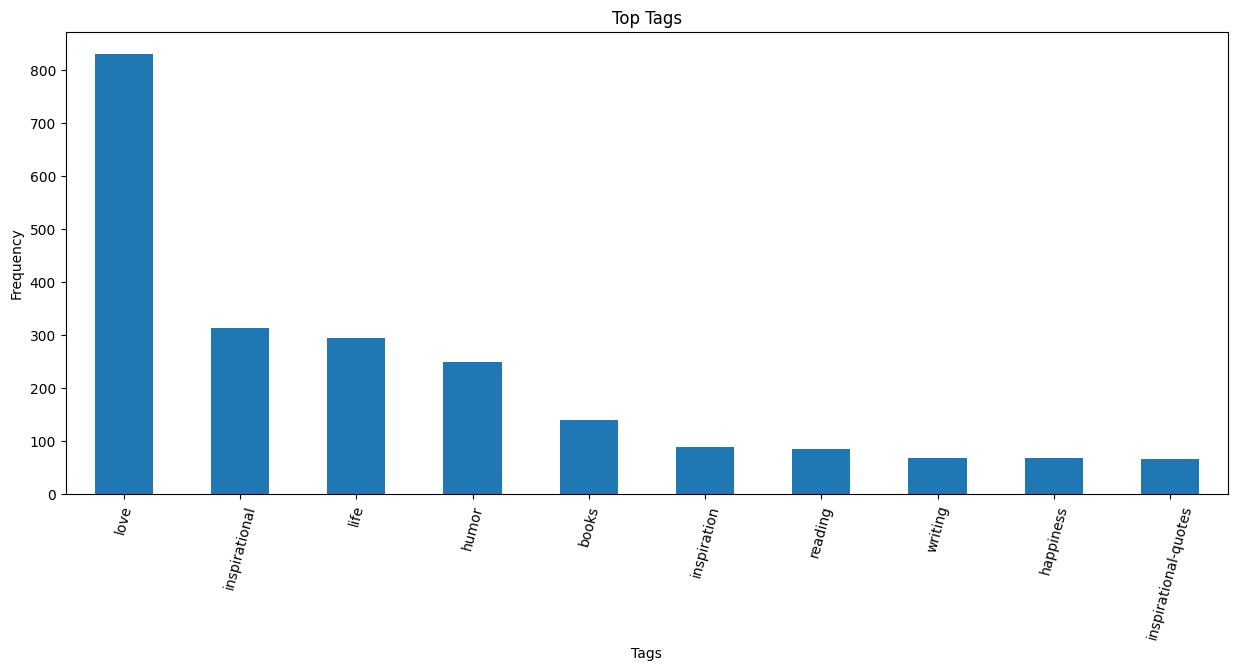

In [73]:
# Extract the 'Tags' column
Tags = quotes_2['Tags']

# Flatten the list of Tags
flat_Tags = [tag for sublist in Tags for tag in sublist]

# Count the frequency of each keyword
keyword_counts = pd.Series(flat_Tags).value_counts().head(10)

# Select the top Tags
top_Tags = keyword_counts.head(20) 

# Plot the top Tags
plt.figure(figsize=(15, 6))
top_Tags.plot(kind='bar')
plt.title('Top Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
# save the figure
#plt.savefig(".data/images/Tags_plot")
plt.show()

In [74]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [75]:
tweets['token_text'] = tweets['selected_text'].apply(preprocesss_text)

In [76]:
tweets['token_text']

0                           responded going
1                                  sooo sad
2                                  bullying
3                               leave alone
4                                      sons
                        ...                
27476                                  lost
27477                                 force
27478                              yay good
27479                                 worth
27480    flirting going atg smiles yay hugs
Name: token_text, Length: 27481, dtype: object

Top selected_text:
good     1253
day      1074
love      911
happy     854
like      774
get       774
go        704
got       659
work      624
going     594
Name: count, dtype: int64


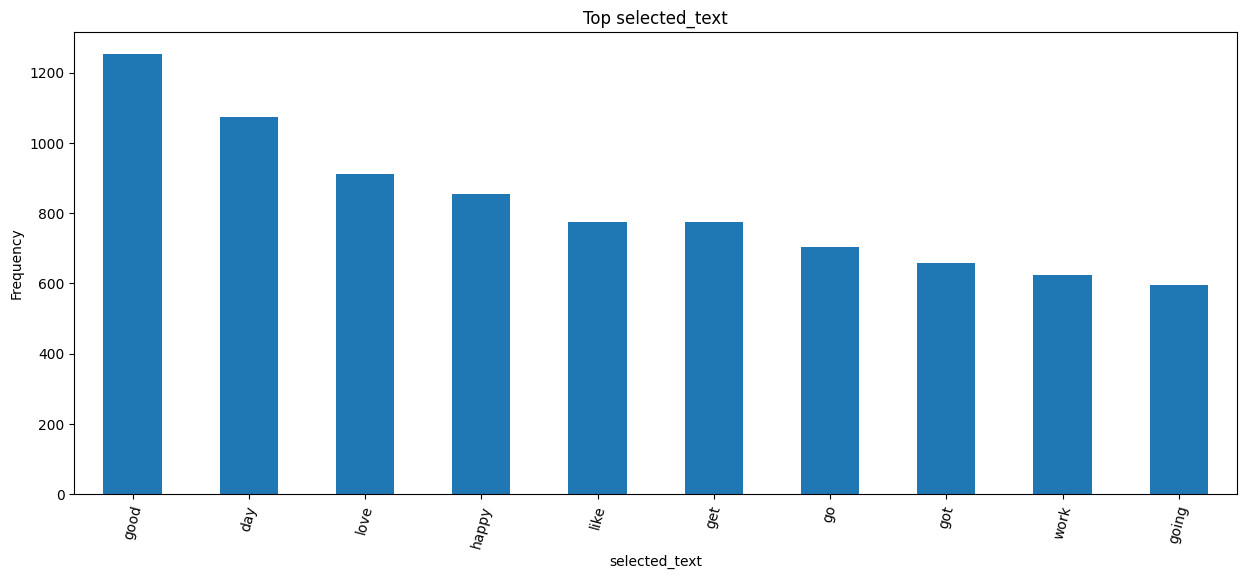

In [77]:
# Extract the 'selected_text' column
selected_text = tweets['token_text']

# Filter out any non-string values
selected_text = selected_text.loc[selected_text.apply(lambda x: isinstance(x, str))]

# Replace any non-alphanumeric characters with a space
selected_text = selected_text.str.replace(r'[^a-zA-Z0-9\\s]', ' ', regex=True)

# Filter out any empty strings or strings with fewer than three characters
selected_text = selected_text.str.strip().str.replace(r'\\s+', ' ').str.split()

# Flatten the list of selected_text
flat_selected_text = [text for sublist in selected_text for text in sublist]

# Count the frequency of each text
text_counts = pd.Series(flat_selected_text).value_counts()

# Select the top selected_text
top_selected_text = text_counts.head(10)

# Check if top_selected_text Series is not empty
if not top_selected_text.empty:
    print("Top selected_text:")
    print(top_selected_text)

    plt.figure(figsize=(15, 6))
    top_selected_text.plot(kind='bar')
    plt.title('Top selected_text')
    plt.xlabel('selected_text')
    plt.ylabel('Frequency')
    plt.xticks(rotation=75)
    plt.show()
else:
    print("Top selected_text is empty. Cannot plot.")


In [78]:
# # Extract the 'spoken_languages' column
# spoken_languages = movies_credits['spoken_languages']

# # Flatten the list of spoken languages
# flat_languages = []
# for sublist in spoken_languages:
#     if isinstance(sublist, str):
#         sublist = ast.literal_eval(sublist)
#     for language in sublist:
#         if isinstance(language, dict):
#             flat_languages.append(language['name'])

# # Count the frequency of each spoken language
# language_counts = pd.Series(flat_languages).value_counts()

# # Select the top spoken languages
# top_languages = language_counts.head(5)  # Change the number to select more or fewer top languages

# # Plot the top spoken languages
# plt.figure(figsize=(10, 6))
# top_languages.plot(kind='bar')
# plt.title('Most Spoken Languages')
# plt.xlabel('Languages')
# plt.ylabel('Frequency')
# plt.savefig('.data/images/most_spoken_languages')
# plt.show()

In [79]:
#  #Get value counts of original languages
# original_language_counts = movies_credits['original_language'].value_counts()

# # Get the top 5 languages
# top_languages = original_language_counts[:5]

# # Calculate the count for the "Others" category
# others_count = original_language_counts[5:].sum()

# # Create a new series with the top 5 languages and "Others"
# languages_data = pd.concat([top_languages, pd.Series(others_count, index=['Others'])])

# # Plotting 'original_language'
# plt.figure(figsize=(12, 12))
# languages_data.plot(kind='pie', autopct='%1.1f%%')
# plt.title('Number of Movies by Original Language')
# plt.ylabel('')

# # Add labels to the pie chart
# plt.legend(labels=languages_data.index)
# plt.savefig('.data/images/no_movies by language')
# plt.show()

### Modelling

We will import the modelling packages right here instead of scrolling back to the top everytime we want to add a new package. 

In [80]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

For Modelling, we will need to gather a data frame of tweets/posts so that we can train the model to reply with an appropriate quote. for this we will get a precleaned data frame from Kaggle and get the tweets since the twitter/X API limited access to pulling tweets and we do not want to go against their regulations. 

In [81]:
quotes_2.head(10)

,Author Name,Tags,quote,author,quote_2,author_2,Compressed_Tags,Tags_
0,Oscar Wilde,"[attributed-no-source, be-yourself, gilbert-pe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde,"[gilbert-perreira, honesty, quote-investigator...","(gilbert-perreira, honesty, quote-investigator..."
1,Marilyn Monroe,"[attributed-no-source, best, life, love, misat...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"[out-of-control, life, truth, worst, mistakes]","(out-of-control, life, truth, worst, mistakes)"
2,Albert Einstein,"[attributed-no-source, human-nature, humor, in...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein,"[humor, infinity, science, human-nature, unive...","(humor, infinity, science, human-nature, unive..."
3,Frank Zappa,"[books, humor]","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa,"[books, humor]","(books, humor)"
4,Marcus Tullius Cicero,"[attributed-no-source, books, simile, soul]",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero,"[books, simile, soul, attributed-no-source]","(books, simile, soul, attributed-no-source)"
5,Bernard M. Baruch,"[ataraxy, be-yourself, confidence, fitting-in,...","“Be who you are and say what you feel, because...",Bernard M. Baruch,"“Be who you are and say what you feel, because...",Bernard M. Baruch,"[misattributed-dr-seuss, ataraxy, fitting-in, ...","(misattributed-dr-seuss, ataraxy, fitting-in, ..."
6,William W. Purkey,"[dance, heaven, hurt, inspirational, life, lov...",“You've gotta dance like there's nobody watchi...,William W. Purkey,“You've gotta dance like there's nobody watchi...,William W. Purkey,"[life, hurt, heaven, dance, love]","(life, hurt, heaven, dance, love)"
7,Dr. Seuss,"[attributed-no-source, dreams, love, reality, ...",“You know you're in love when you can't fall a...,Dr. Seuss,“You know you're in love when you can't fall a...,Dr.Sewer,"[reality, sleep, love, dreams, attributed-no-s...","(reality, sleep, love, dreams, attributed-no-s..."
8,Mae West,"[humor, life]","“You only live once, but if you do it right, o...",Mae West,"“You only live once, but if you do it right, o...",Mae West,"[life, humor]","(life, humor)"
9,Mahatma Gandhi,"[action, change, inspirational, misattributed-...",“Be the change that you wish to see in the wor...,Mahatma Gandhi,“Be the change that you wish to see in the wor...,Mahatma Gandhi,"[change, philosophy, misattributed-to-gandhi, ...","(change, philosophy, misattributed-to-gandhi, ..."


In [82]:
tweets.head(10)

,textID,text,selected_text,sentiment,token_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http shameless plugging best rangers forum earth
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,fun
7,50e14c0bb8,Soooo high,Soooo high,neutral,soooo high
8,e050245fbd,Both of you,Both of you,neutral,
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,wow u became cooler


In [83]:
tweets_sample = tweets.sample(3000).reset_index(drop=True)

In [84]:
tweets_sample.head(10)

,textID,text,selected_text,sentiment,token_text
0,2617b9c9e3,Just got confirmed that itï¿½s pizza-time with...,looking forward to it,positive,looking forward
1,ce0025d376,"ack, no can see either. and weird, these tw...",nd weir,negative,nd weir
2,81a218143d,_Vincent @ i missed the party!!!! i bought...,@ i missed the party!!!! i bought wine and ev...,negative,missed party bought wine everything
3,770e0ec279,"I`m pissed, someone took my wallet","pissed,",negative,pissed
4,32379cee09,"Happy 'Star Wars' Day, Twitters. http://migre...","Happy 'Star Wars' Day,",positive,happy wars day
5,2af5610991,"that was flippin` sweet, dudes. thanks for ...",es. thank,positive,es thank
6,5328c72bfd,OMG I`M SOO EXCITED! i`ve been waiting for it...,OMG I`M SOO EXCITED!,positive,omg soo excited
7,4e3a9d1c15,My ipod has taken it`s last breath... Im truly...,truly devastated.,negative,truly devastated
8,daa69a6eb3,Norwood house party haaaaaa... Yaaaaaaay (smi...,Norwood house party haaaaaa... Yaaaaaaay (smiles),positive,norwood house party haaaaaa yaaaaaaay smiles
9,f4d97a5add,i don`t have texting.....,i don`t have texting.....,neutral,texting


In [85]:
# Preprocess quotes
quotes_2['processed_quote'] = quotes_2['quote_2'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.isalnum()]))
# Preprocess tweets
tweets_sample['processed_text'] = tweets_sample['token_text'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(str(x)) if word.isalnum()]))

# Combine quotes and tweets for vectorization
# combined_text = pd.concat([quotes_2['processed_quote'], tweets_sample['processed_text']])
combined_text = quotes_2['processed_quote']
# print(combined_text)
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

print(tfidf_vectorizer)
print(tfidf_matrix.shape) # (n_samples, n_features)
# Calculate cosine similarity between tweets and quotes
cosine_similarities = linear_kernel(tfidf_matrix[:len(quotes_2)])

print(cosine_similarities)
print("Length of quotes_2:", len(quotes_2))
print("Size of cosine_similarities array:", cosine_similarities.shape[0])


# Initialize an empty list for recommendations
tweet_recommendations = []

# Iterate through each tweet and recommend a quote
for i, row in tweets_sample.iterrows():
    # Ensure tweet index is within bounds
    tweet_idx = len(quotes_2) + i
    if tweet_idx < cosine_similarities.shape[0]:
        # Calculate similar quotes indices
        most_similar_index = np.argmax(cosine_similarities[tweet_idx])
        # Check if any similar quotes are found
        if cosine_similarities[tweet_idx][most_similar_index] > 0:
            # Get the most similar quote
            recommended_quote = quotes_2.loc[most_similar_index, 'quote']
            tweet_recommendations.append(recommended_quote)
        else:
            # Handle the case when no similar quotes are found
            tweet_recommendations.append("No similar quotes found.")
    else:
        # Handle the case when tweet index is out of bounds
        tweet_recommendations.append("Invalid tweet index.")

# Add the recommendations to the tweets_sample DataFrame
tweets_sample['recommended_quote'] = tweet_recommendations

# Display the final recommendations
print(tweets_sample[['text', 'recommended_quote']])


TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])
(3000, 7397)
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.06365195 ... 0.         0.06163262 0.05047965]
 [0.         0.06365195 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.06163262 0.         ... 0.         1.         0.        ]
 [0.         0.05047965 0.         ... 0.         0.         1.        ]]
Length of quotes_2: 3000
Size of cosine_similarities array: 3000
                                                  

Since that has proved not to be effective, we will proceed with another  approach. Below we will go ahead and do sentiment analysis for the quotes, thereby mapping the sentiment wether positive, negative or neutral. <br>
Sentiment analysis is a common natural language processing (NLP) task that involves determining the emotional tone behind words to gain an understanding of the attitudes, opinions, and emotions expressed within an online mention. In Python, there are several libraries that can help you perform sentiment analysis, such as TextBlob and Vader Sentiment.<br>
For our case we will use TextBlob ans we will follow the following steps. 
First, you'll need to install the TextBlob library. You can do this using pip: pip install textblob 
Then restart kernel and import it with the other packages. 

In [86]:
quotes_blob = quotes_2['quote_2']
for quote in quotes_blob:
    blob = TextBlob(quote)
    sentiment = blob.sentiment
    print(f"Quote: {quote}")
    print(f"Sentiment: {sentiment}")
    print()

Quote: “Be yourself;Everyone else is already taken. ”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.”
Sentiment: Sentiment(polarity=-0.14739583333333334, subjectivity=0.7506944444444444)

Quote: “Two things are infinite: the universe and human stupidity; and I'm not sure about the universe.”
Sentiment: Sentiment(polarity=-0.2833333333333333, subjectivity=0.662962962962963)

Quote: “So many books, so little time.”
Sentiment: Sentiment(polarity=0.15625, subjectivity=0.5)

Quote: “A room without books is like a body without a soul.”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “Be who you are and say what you feel, because those who mind don't matter, and those who matter don't mind.”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “You've gotta 

The sentiment attribute of the TextBlob object returns a Sentiment object with two attributes: polarity and subjectivity. The polarity attribute ranges from -1 (negative) to 1 (positive) and measures the overall tonality of the text. The subjectivity attribute ranges from 0 (objective) to 1 (subjective) and measures the amount of personal opinion and factual information contained in the text.

In [87]:
def get_sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"
    
# Perform sentiment analysis and add a new column with the sentiment category
quotes_2['sentiment'] = quotes_2['quote_2'].apply(lambda x: get_sentiment_category(TextBlob(x).sentiment.polarity))

In [88]:
quotes_2[['quote_2','sentiment']]

,quote_2,sentiment
0,“Be yourself;Everyone else is already taken. ”,neutral
1,"“I'm selfish, impatient and a little insecure....",negative
2,“Two things are infinite: the universe and hum...,negative
3,"“So many books, so little time.”",positive
4,“A room without books is like a body without a...,neutral
...,...,...
2995,“I'm not lost for I know where I am. But howev...,neutral
2996,“Dreams are the touchstones of our characters.”,neutral
2997,“Black hair and blue eyes are my favorite comb...,positive
2998,“In times of grief and sorrow I will hold you ...,negative


In [89]:
list(quotes_2['sentiment'].loc[10:100])

['neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'positive

Based on a small sample, it seems that TextBlob may not be the most accurate in categorizing the sentiments of these quotes. The majority of the quotes were labeled as 'neutral' by TextBlob, while our manual analysis categorized them as 'positive' or 'negative'. This discrepancy suggests that TextBlob's sentiment analysis may not be fine-tuned for these types of quotes.<br>
To improve the sentiment analysis for this kind of dataset, we may consider using more advanced techniques, such as training a custom model using machine learning algorithms.<br> This would allow the model to learn the unique characteristics of the dataset and improve the accuracy of the sentiment analysis.

To improve the sentiment analysis for the dataset using a custom machine learning model, we can follow these steps:

> 1. Prepare and preprocess the data.
> 2. Choose a machine learning algorithm.
> 3. Train the model.
> 4. Evaluate the model.
> 5. Fine-tune and optimize the model.

In [90]:
tweets

,textID,text,selected_text,sentiment,token_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,lost
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,force
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth


In [91]:
quotes_2

,Author Name,Tags,quote,author,quote_2,author_2,Compressed_Tags,Tags_,processed_quote,sentiment
0,Oscar Wilde,"[attributed-no-source, be-yourself, gilbert-pe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde,"[gilbert-perreira, honesty, quote-investigator...","(gilbert-perreira, honesty, quote-investigator...",be yourself everyone else is already taken,neutral
1,Marilyn Monroe,"[attributed-no-source, best, life, love, misat...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"[out-of-control, life, truth, worst, mistakes]","(out-of-control, life, truth, worst, mistakes)",i selfish impatient and a little insecure i ma...,negative
2,Albert Einstein,"[attributed-no-source, human-nature, humor, in...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein,"[humor, infinity, science, human-nature, unive...","(humor, infinity, science, human-nature, unive...",two things are infinite the universe and human...,negative
3,Frank Zappa,"[books, humor]","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa,"[books, humor]","(books, humor)",so many books so little time,positive
4,Marcus Tullius Cicero,"[attributed-no-source, books, simile, soul]",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero,"[books, simile, soul, attributed-no-source]","(books, simile, soul, attributed-no-source)",a room without books is like a body without a ...,neutral
...,...,...,...,...,...,...,...,...,...,...
2995,"A.A. Milne,",[love],“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh",“I'm not lost for I know where I am. But howev...,"A.A.Milne,",[love],"(love,)",i not lost for i know where i am but however w...,neutral
2996,Henry David Thoreau,[love],“Dreams are the touchstones of our characters.”,Henry David Thoreau,“Dreams are the touchstones of our characters.”,Henry David Thoreau,[love],"(love,)",dreams are the touchstones of our characters,neutral
2997,"Cassandra Clare,",[love],“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel",“Black hair and blue eyes are my favorite comb...,"Cassandra Clare,",[love],"(love,)",black hair and blue eyes are my favorite combi...,positive
2998,"Nicholas Sparks,",[love],“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook",“In times of grief and sorrow I will hold you ...,"Nicholas Sparks,",[love],"(love,)",in times of grief and sorrow i will hold you a...,negative


In [92]:
# Data
tweets_df = tweets.iloc[:,'selected_text']
quotes_df = quotes_2.iloc[:, 'quote_2']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types